In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

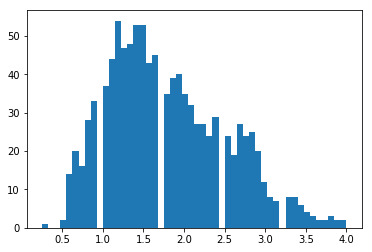

In [8]:
plt.hist(phone_df.age.values, bins = 50);

In [9]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


In [10]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


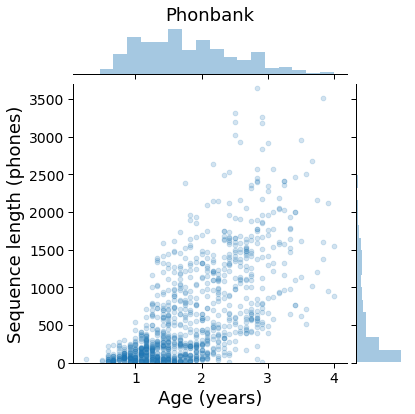

In [11]:
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":18,"axes.labelsize":18, "axes.ticksize":14})   

p = sns.jointplot("age", "n_phones", data=phone_df, alpha=0.2, annot_kws={"size": 16})

p.set_axis_labels(xlabel="Age (years)", ylabel="Sequence length (phones)")
p.ax_joint.tick_params(labelsize=14)
p.ax_marg_x.set_title("Phonbank")
p.ax_joint.set_ylim([0,3700])
#save_fig(FIGURE_DIR/ 'distributions' / 'phonbank_distribution')
plt.show()

In [12]:
np.median(phone_df.n_phones)

306.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [13]:
from childes_mi.information_theory import mutual_information as mi

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.expected_mutual_info_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [14]:
distances = np.arange(1,101)

#### Run MI by age cohort

In [15]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [16]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [17]:
### sequence length by cohort

In [18]:
def concat(arr):
    """ingore concatenation of zero length list"""
    if len(arr) ==0:
        return []
    else:
        return np.concatenate(arr)

In [19]:
def remove_repeats(sequence):
    if len(sequence) == 0:
        return sequence
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

In [20]:
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    median_n_phones = np.median(cohort_subset.n_phones.values)
    print(age_cohort_low, age_cohort_high, median_n_phones)

0.5 1 69.5
1 1.5 189.0
1.5 2 276.0
2 2.5 879.0
2.5 3 1150.0
3 20 1574.0



In [21]:
def quickplot_decay(distances, MI, shuff_MI, title=''):
    fig,axs = plt.subplots(ncols=2, figsize = (10,4))
    ax = axs[0]
    ax.set_title(title)
    ax.scatter(distances, MI-shuff_MI)
    ax.plot(distances, MI-shuff_MI, alpha = 0)
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax = axs[1]
    ax.scatter(distances, MI)
    ax.scatter(distances, shuff_MI)
    plt.show()

In [22]:
cohort_subset[:4]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,030119,3.167,Providence,eng,male,"[[ˈjɛs], [ˈpliz], [ˈlʊk], [ˈhaɪ, ˈdʒiˈdʒi], [ˈ...","[[yes], [please], [look], [hi, Gigi], [yyy, yy...",/mnt/cube/tsainbur/Projects/github_repos/child...,2180
0,0,030200,3.167,Providence,eng,male,"[[ˈo, ˈjɛs], [pʰəːˈleɪːˈdo, ə, ˈlaɪk, ˈnu, wən...","[[oh, yes], [Play_Doh, I, like, new, one], [I,...",/mnt/cube/tsainbur/Projects/github_repos/child...,2045
0,0,030301,3.250,Providence,eng,male,"[[None], [ˈʌm, ˈno], [None], [None], [None], [...","[[xxx], [&-um, no], [xxx], [xxx], [xxx], [yyy,...",/mnt/cube/tsainbur/Projects/github_repos/child...,1575
0,0,030214,3.167,Providence,eng,male,"[[None], [ˈlok], [ˈjɛs], [mə, ˈhi], [ˈmʌɪ, ˈwʌ...","[[xxx], [look], [yes], [my, piece], [Mommy, wa...",/mnt/cube/tsainbur/Projects/github_repos/child...,1606


phones list: ˈ j ɛ s ˈ p l i z ˈ l ʊ k ˈ h a ɪ ˈ d ʒ i ˈ d ʒ i ˈ w ʌ ˈ d o i ˈ w ɛ z ˈ s t ɛ l ə z ˈ ɡ ɪ n * ˈ s 
phones list (shuffled within transcript): ˈ j ɛ s ˈ p l i z ˈ l ʊ k ˈ h a ɪ ˈ d ʒ i ˈ d ʒ i ˈ w ʌ ˈ d o i ˈ w ɛ z ˈ s t ɛ l ə z ˈ ɡ ɪ n * ˈ s 
phones list (no repeats): ˈ j ɛ s ˈ p l i z ˈ l ʊ k ˈ h a ɪ ˈ d ʒ i ˈ d ʒ i ˈ w ʌ ˈ d o i ˈ w ɛ z ˈ s t ɛ l ə z ˈ ɡ ɪ n * ˈ s 
phones list (shuffled within word): ɛ ˈ j s l ˈ i p z k l ˈ ʊ ɪ a h ˈ ˈ ˈ ʒ d i d ʒ i ʌ ˈ w o ˈ d i ɛ z w ˈ s t ɛ ˈ z l ə ˈ ɪ n ɡ * s i 
phones list (shuffled between word): ɪ ˈ f ɔ ˈ ʌ ˈ j e ɪ ə ˈ w ɑ ɪ s ˈ p ʌ n i ˈ l ʊ k ˈ w a ʊ ˈ w ɑ t ɪ ə ˈ d u ə ˈ ɑ n ˈ w ɑ t ɜ ˞ r ˈ 
phones list (shuffled within utterances): j ɛ ˈ s z p ˈ i l ˈ k l ʊ d ɪ d i ˈ ʒ ʒ a ˈ h ˈ i i ˈ w o d ˈ ʌ ɛ ɪ ˈ z ˈ z n s ɡ l t ɛ ˈ w ə n * m 
phones list (shuffled between utterances): ˈ w i ˈ d ɪ d ˈ ɪ t ˈ w i ˈ d ɪ d ˈ ɪ t ˈ w i ˈ d ɪ d ˈ ɪ t ˈ ɛ n d ˈ w i ˈ d ʌ l ə ˈ w o ɡ ə ˈ m i 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   16.1s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   13.2s finished


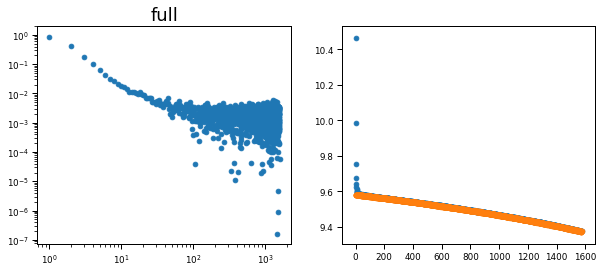

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:    4.2s finished


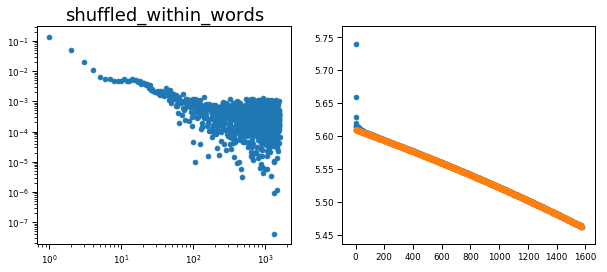

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   12.3s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   13.3s finished


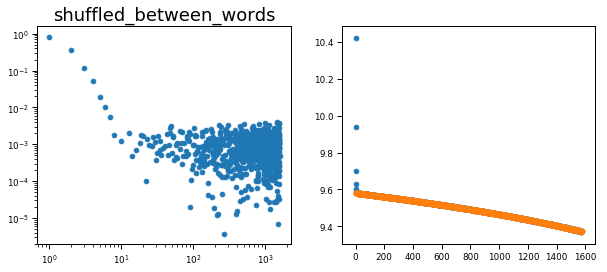

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   12.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   13.2s finished


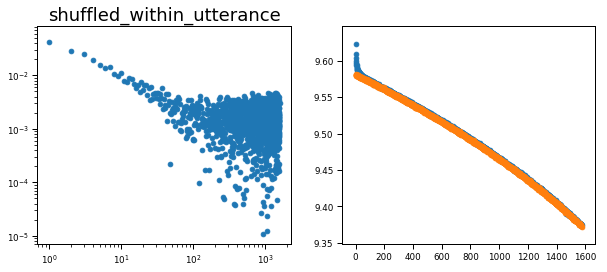

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   12.2s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   13.2s finished


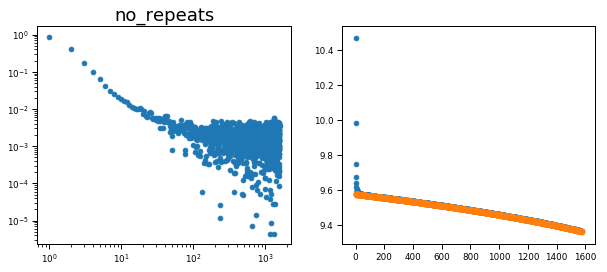

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   12.3s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   13.3s finished


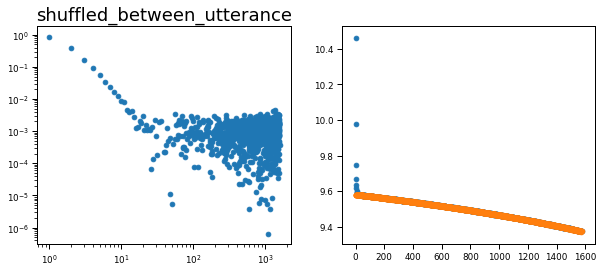

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   12.5s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:   13.2s finished


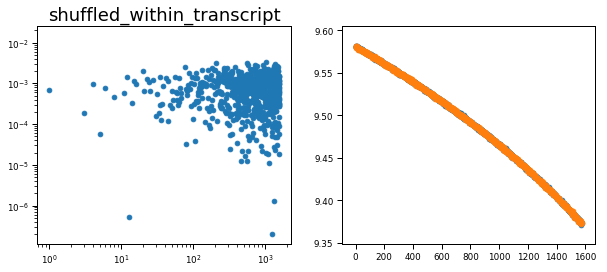

phones list: ˈ h i ˈ h æ r ə s ˈ h i ˈ h æ r ə s ˈ k æ v ə ʔ ˈ p l i s ˈ ʊ p s ˈ n o ˈ w a ɪ f ˈ n ʌ ˈ n ʌ ˈ n o 
phones list (shuffled within transcript): ˈ h i ˈ h æ r ə s ˈ h i ˈ h æ r ə s ˈ k æ v ə ʔ ˈ p l i s ˈ ʊ p s ˈ n o ˈ w a ɪ f ˈ n ʌ ˈ n ʌ ˈ n o 
phones list (no repeats): ˈ h i ˈ h æ r ə s ˈ h i ˈ h æ r ə s ˈ k æ v ə ʔ ˈ p l i s ˈ ʊ p s ˈ n o ˈ w a ɪ f ˈ n ʌ ˈ n ʌ ˈ n o 
phones list (shuffled within word): ˈ i h æ ˈ h s r ə h i ˈ æ h ˈ ə r s ə k æ ʔ ˈ v s l ˈ p i ˈ s ʊ p o n ˈ a ɪ w f ˈ ˈ n ʌ ʌ n ˈ o n ˈ 
phones list (shuffled between word): ˈ ð æ t ˈ w ɛ ʃ t ʃ w ə ˈ h ɔ s ə z ˈ ɪ t s ˈ m ɑ ː ˈ ɪ t ˈ s p a ɪ ə e ɪ ˈ j ɑ m ɪ ˈ b i ˈ n æ n ə 
phones list (shuffled within utterances): h h r s ˈ ˈ ə æ i r ˈ ˈ ə æ i h s h ˈ k ˈ æ ə s ʔ i l p v p s ˈ ʊ o ˈ n w ɪ ˈ a f ˈ o n n ˈ ʌ n ˈ ʌ 
phones list (shuffled between utterances): ˈ n a ɪ ˈ p ʊ t d ə ˈ t ɔ ɪ z ə ˈ w e ɪ ˈ m ɑ m i ˈ w ʊ p ˈ b ɔ ɪ ŋ * ə ˈ r ɛ d ˈ h æ t ˈ w o * ˈ w 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   16.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   17.8s finished


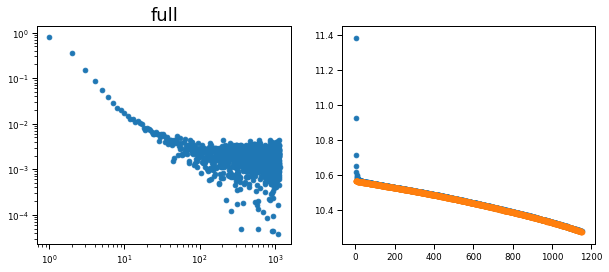

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:    4.5s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:    5.4s finished


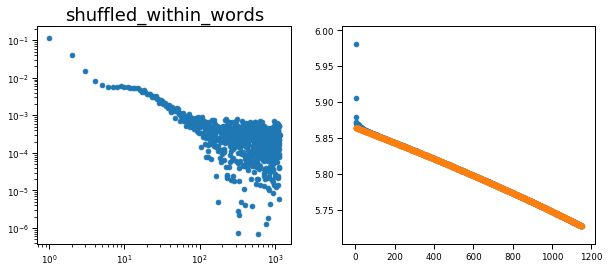

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   16.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   17.9s finished


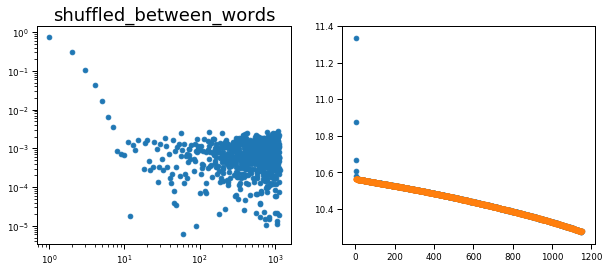

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   16.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   17.8s finished


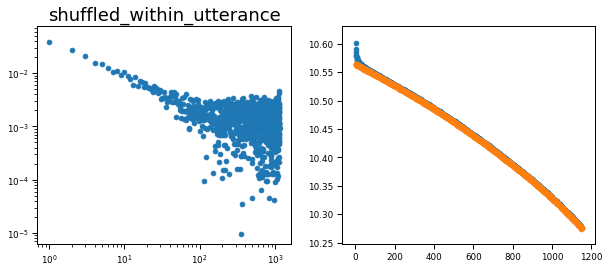

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   16.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   17.7s finished


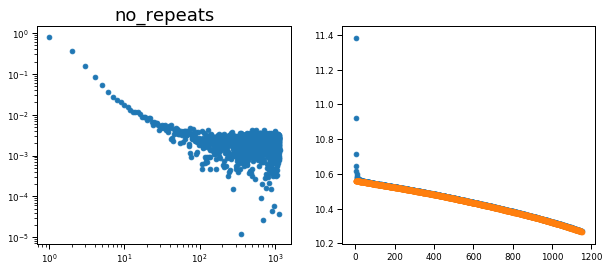

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   16.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   17.8s finished


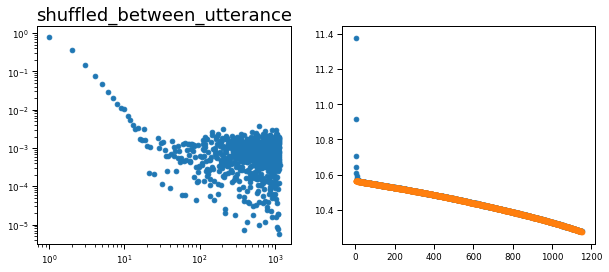

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   16.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   17.9s finished


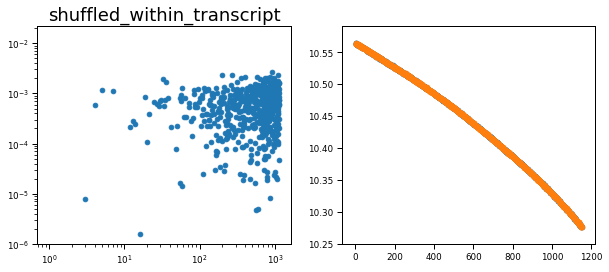

phones list: ˈ ɛ z ɑ ˈ b o k * ˈ m ɑ m i e ɪ ˈ w ɪ m ˈ ɛ ː ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ 
phones list (shuffled within transcript): ˈ ɛ z ɑ ˈ b o k * ˈ m ɑ m i e ɪ ˈ w ɪ m ˈ ɛ ː ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ 
phones list (no repeats): ˈ ɛ z ɑ ˈ b o k * ˈ m ɑ m i e ɪ ˈ w ɪ m ˈ ɛ ː ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ 
phones list (shuffled within word): ɛ ˈ z k b ˈ o ɑ * ˈ i m m ɑ m w ɪ e ˈ ɪ ˈ ː ɛ m i ˈ m ɑ ɛ ˈ ˈ i m ɑ m ɛ ˈ ˈ m ɑ i m ɛ ˈ ˈ m ɑ i m ʌ 
phones list (shuffled between word): ˈ ɛ m e ɪ ˈ w i ˈ t ʃ i s ˈ ʌ m a ɪ i æ ˈ ɑ p ə w o ˈ h ɛ ˈ b i ɜ ˞ ˈ ɛ m ˈ z i ə ˈ ɛ ˈ e ɪ u w ˈ m 
phones list (shuffled within utterances): z ɛ b k ˈ ɑ ˈ o ˈ ɪ m m i e ɑ w m * ˈ ɪ m ˈ i ɑ m ˈ ː ɛ m i ɛ m ɑ ˈ ˈ ɑ m ˈ m ˈ ɑ ɛ ˈ m i m i ˈ ɛ ˈ 
phones list (shuffled between utterances): ˈ w e ɪ * ə ˈ m ɑ m ˈ l ɑ m e ɪ ˈ b u ˈ w ɪ ˈ p i ˈ w a ɪ ˈ o ˈ b ɔ ˈ h ʌ m ˈ m ʌ m ə m ə ˈ ɡ w i ˈ 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   12.9s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   13.6s finished


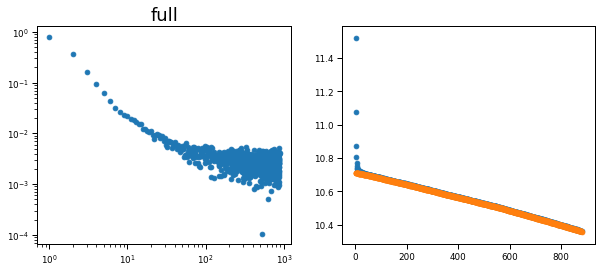

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 816 out of 879 | elapsed:    3.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 816 out of 879 | elapsed:    4.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:    4.3s finished


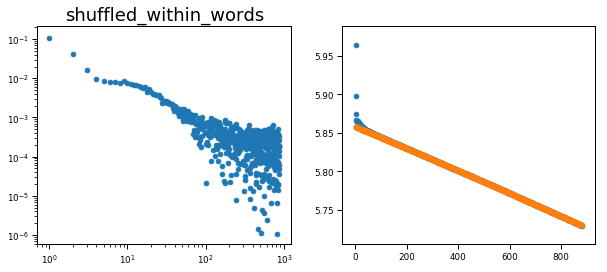

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   12.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   13.7s finished


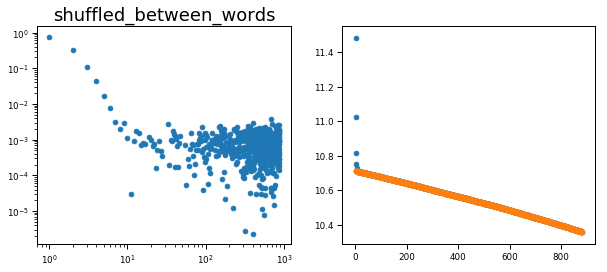

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   12.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   13.6s finished


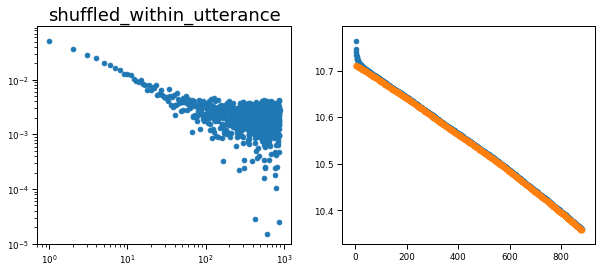

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   12.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   13.7s finished


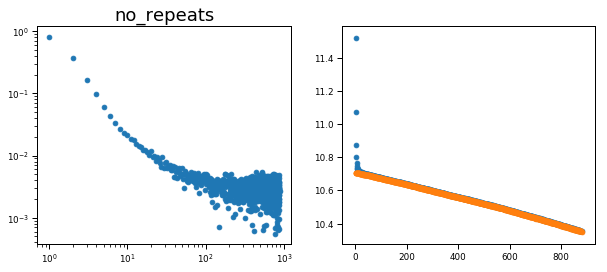

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   12.9s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   13.7s finished


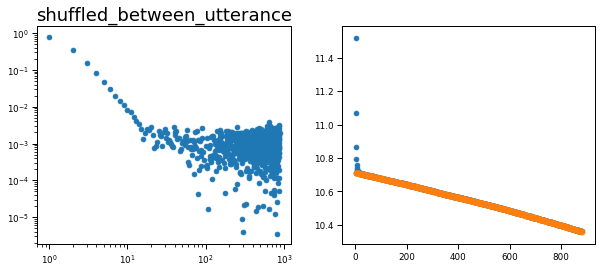

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   12.9s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   13.7s finished


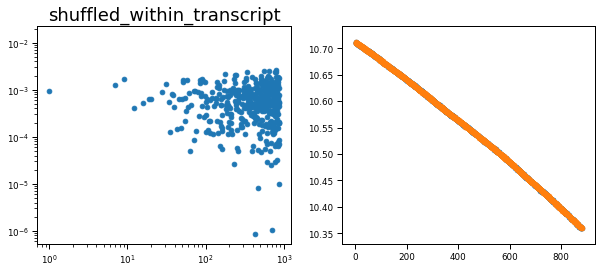

phones list: h ɪ ˈ m i ˈ b u ə ˈ h ɪ t s ɪ * ʊ ˈ h ʌ ə ˈ b u * ˈ h e ɪ ː ˈ ʌ t ˈ m ɑ m i ɪ ˈ s i ɾ w ə ˈ s æ ʔ ˈ 
phones list (shuffled within transcript): h ɪ ˈ m i ˈ b u ə ˈ h ɪ t s ɪ * ʊ ˈ h ʌ ə ˈ b u * ˈ h e ɪ ː ˈ ʌ t ˈ m ɑ m i ɪ ˈ s i ɾ w ə ˈ s æ ʔ ˈ 
phones list (no repeats): h ɪ ˈ m i ˈ b u ə ˈ h ɪ t s ɪ * ʊ ˈ h ʌ ə ˈ b u * ˈ h e ɪ ː ˈ ʌ t ˈ m ɑ m i ɪ ˈ s i ɾ w ə ˈ s æ ʔ ˈ 
phones list (shuffled within word): ɪ h m i ˈ b u ˈ ə ˈ h s t ɪ ɪ * ʊ ʌ h ˈ ə u b ˈ * h ɪ ˈ e ː t ˈ ʌ m ˈ ɑ m i ɪ i s ˈ ɾ s ə ˈ ʔ æ w e 
phones list (shuffled between word): ˈ t u ʃ i t w i ˈ s æ ˈ b i b i a ɪ ˈ m ʌ m i ˈ w ʌ n w ə ˈ s æ ː ˈ w ɛ ː ˈ d i d i ˈ a ɪ ˈ ʌ ˈ d i 
phones list (shuffled within utterances): h m ɪ ˈ i b ˈ u * ɪ ˈ ɪ t ʌ ə ʊ h ˈ h s ˈ b u ə h ˈ e * ɪ ː ʌ ˈ t m ɑ i m ˈ i s ɾ ɪ ˈ w ə æ ˈ ʔ s ʌ 
phones list (shuffled between utterances): b ɑ ˈ p ɑ p * ˈ w ʌ n e ɪ ˈ s i ˈ m ɑ m i ˈ ɑ j ɪ ˈ ɡ ɑ ˈ ʔ w ʌ n ˈ ɑ m o ˈ w ʌ n ˈ j ɑ ː * ˈ h i w 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.4s finished


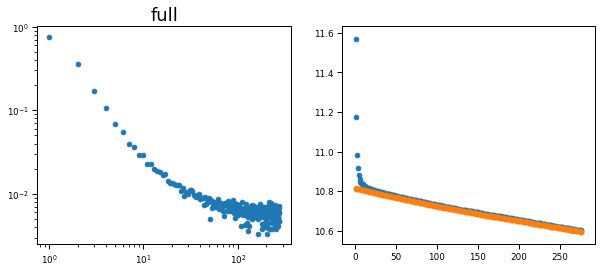

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    1.4s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    1.7s finished


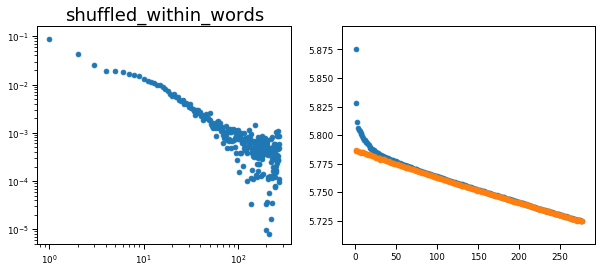

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.4s finished


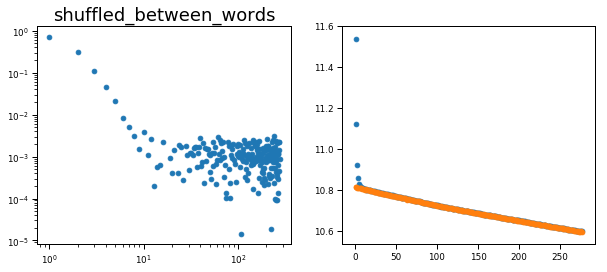

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.4s finished


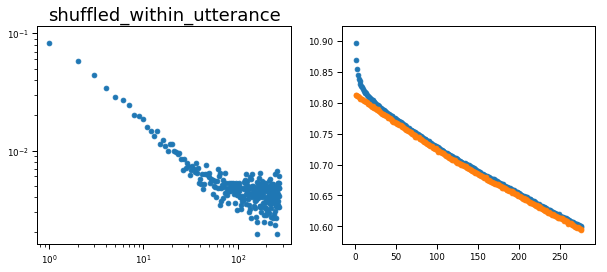

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.4s finished


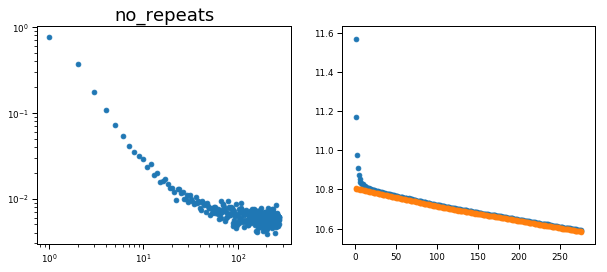

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.5s finished


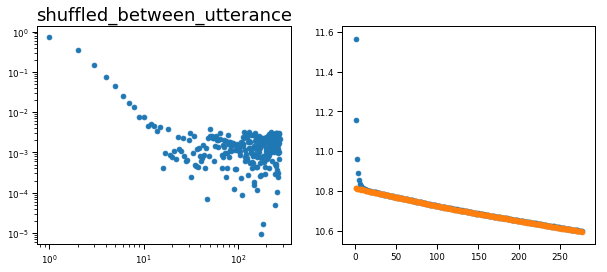

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    4.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    4.5s finished


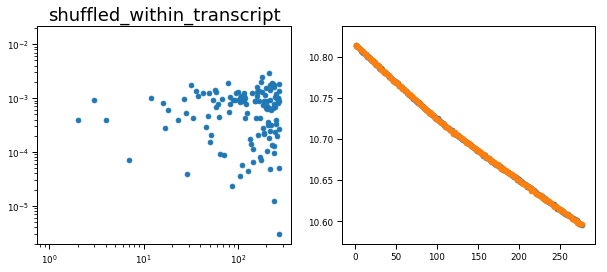

phones list: ˈ a ʊ ˈ u ˈ i ˈ ɑ ˈ ɔ ˈ e ɪ ð i ˈ ð a ʊ ˈ ɪ z ˈ æ j ˈ ɪ ˈ ʌ ɔ ˈ ɔ ː ʔ ə ˈ ɔ ː ʔ ə ˈ o ˈ i ː ˈ i ː ˈ 
phones list (shuffled within transcript): ˈ a ʊ ˈ u ˈ i ˈ ɑ ˈ ɔ ˈ e ɪ ð i ˈ ð a ʊ ˈ ɪ z ˈ æ j ˈ ɪ ˈ ʌ ɔ ˈ ɔ ː ʔ ə ˈ ɔ ː ʔ ə ˈ o ˈ i ː ˈ i ː ˈ 
phones list (no repeats): ˈ a ʊ ˈ u ˈ i ˈ ɑ ˈ ɔ ˈ e ɪ ð i ˈ ð a ʊ ˈ ɪ z ˈ æ j ˈ ɪ ˈ ʌ ɔ ˈ ɔ ː ʔ ə ˈ ɔ ː ʔ ə ˈ o ˈ i ː ˈ i ː ˈ 
phones list (shuffled within word): ˈ a ʊ u ˈ i ˈ ɑ ˈ ɔ ˈ ð i ˈ ɪ e ð a ˈ ʊ z ɪ ˈ ˈ j æ ˈ ɪ ɔ ˈ ʌ ː ˈ ɔ ʔ ə ɔ ː ʔ ˈ ə o ˈ i ː ˈ i ˈ ː i 
phones list (shuffled between word): w ɪ ˈ l o ɛ ˈ n e ɪ ˈ o ː ˈ ɪ ʰ ˈ b u b u ˈ s ɛ ˈ d ɪ ˈ ɑ ˈ b u ː ˈ ɪ ː ə ˈ p ɔ ː e ɪ ˈ t ʃ æ ˈ w i 
phones list (shuffled within utterances): ʊ ˈ a ˈ u ˈ ˈ i ˈ ɑ ɔ a i ʊ ð ˈ ˈ ɪ ð e ˈ ɪ z j æ ˈ ˈ ɪ ʌ ɔ ˈ ɔ ˈ ː ʔ ə ː ɔ ʔ ə ˈ ˈ o ː ˈ i i ˈ ː i 
phones list (shuffled between utterances): ˈ w i ə ˈ m ʌ m ˈ m ʌ m ˈ m ʌ ˈ ɑ ː ˈ w ʌ b ə ˈ b ʌ ˈ ɔ ˈ ʌ ɪ s ˈ t ʌ ˈ ɪ ʔ ˈ i ː ˈ h ɪ t ˈ ɡ ɪ d ˈ 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.7s finished


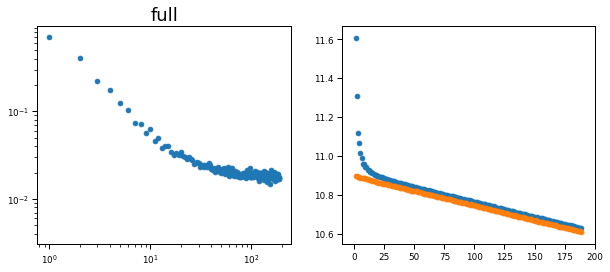

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of 189 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  88 out of 189 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.1s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of 189 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  88 out of 189 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.1s finished


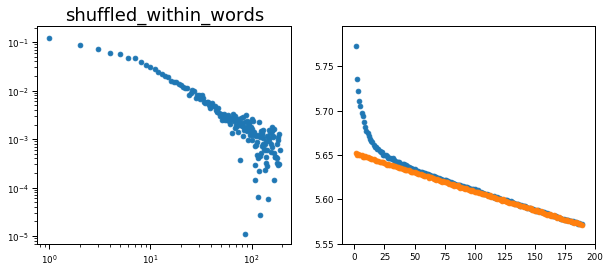

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.5s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.6s finished


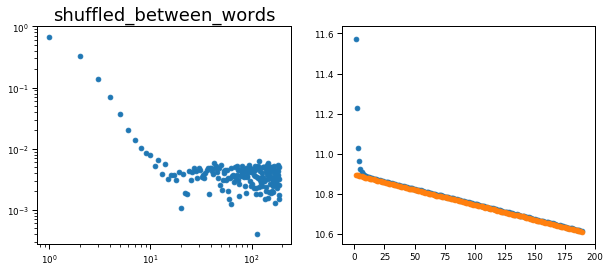

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.5s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.7s finished


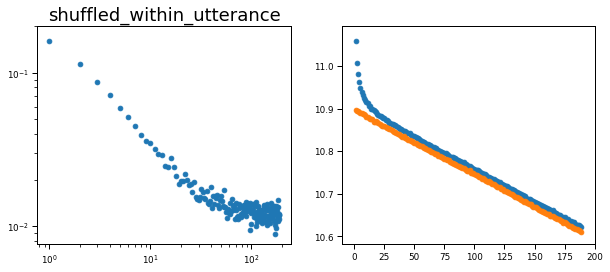

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.5s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.8s finished


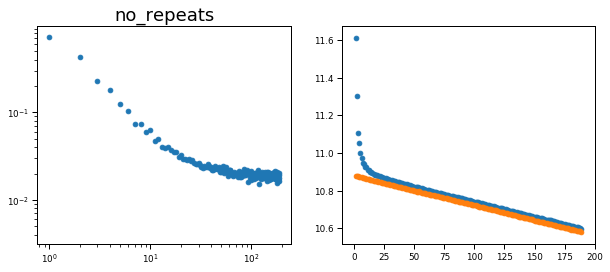

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.7s finished


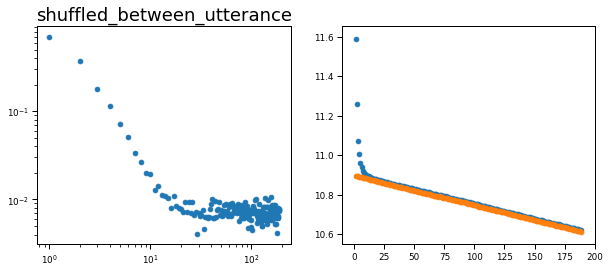

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    2.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.8s finished


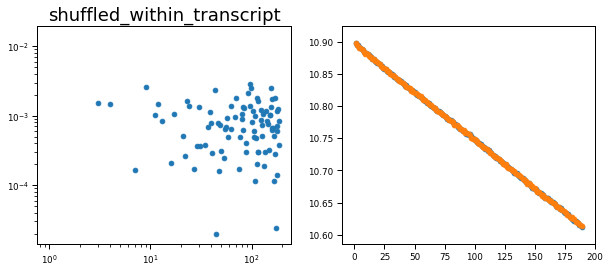

phones list: ˈ n a ɪ ʌ ˈ j ɪ ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ 
phones list (shuffled within transcript): ˈ n a ɪ ʌ ˈ j ɪ ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ 
phones list (no repeats): ˈ n a ɪ ʌ ˈ j ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ m 
phones list (shuffled within word): ɪ n a ˈ ɪ ˈ ʌ j ˈ b m ʌ ɪ ʌ b ˈ m ə ˈ d ɛ ɑ ˈ ɛ ˈ b i ˈ m ˈ ɪ b ˈ ʌ ɪ ɛ a t ˈ ˈ ɪ ɡ ɡ a ˈ ɪ ˈ d ʌ m 
phones list (shuffled between word): ˈ ʔ ʌ m ˈ k ɛ ˈ ɡ ə m i ˈ m ɪ ˈ ʔ ɛ ˈ d æ ˈ ʌ ˈ b ɛ ˈ d ɛ ˈ d e ɪ ˈ h ɛ ˈ k i u ˈ ɡ ɪ ˈ a ɪ ˈ l ɛ ɛ 
phones list (shuffled within utterances): ˈ ɪ a n j ˈ ɪ ʌ ˈ ʌ b m ɪ ʌ ə ˈ b m d ˈ ɛ ɑ ˈ b ˈ ɛ i m ˈ ɪ b ˈ ˈ ʌ t a ɛ ˈ ɪ ɡ ɪ ɪ ɡ ˈ a ˈ ˈ d ʌ m 
phones list (shuffled between utterances): ˈ ɑ ː m ˈ m j ɛ ˈ ɛ ʔ ˈ d ɛ ɛ ˈ b w o ˈ h ɑ ˈ o ˈ ɡ e ɪ ˈ ɡ ɛ ˈ a ɪ ˈ n a ɪ ˈ d æ ˈ d ʌ ˈ h ɛ h ɛ ˈ 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


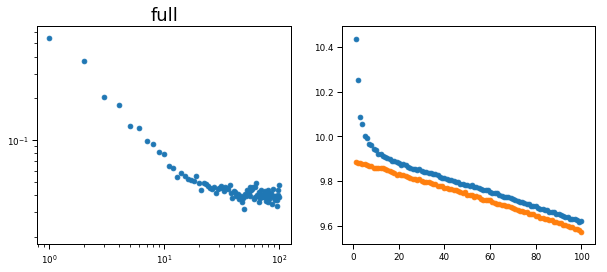

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of 100 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of 100 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


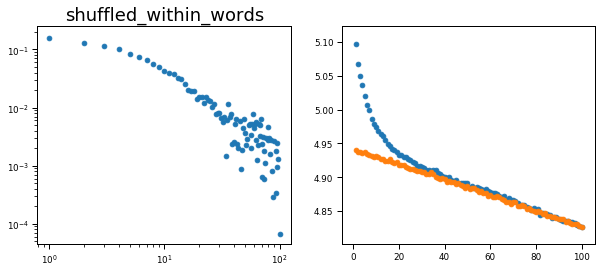

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of 100 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


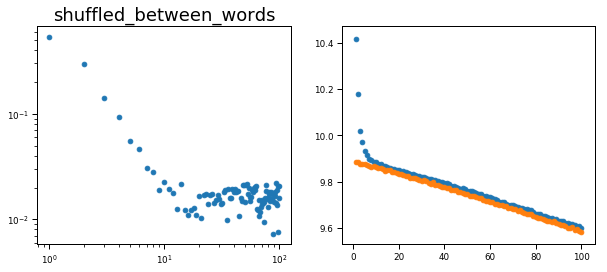

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of 100 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


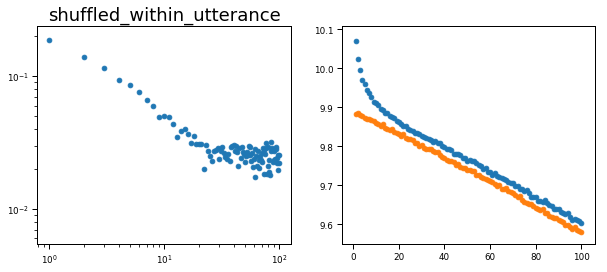

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


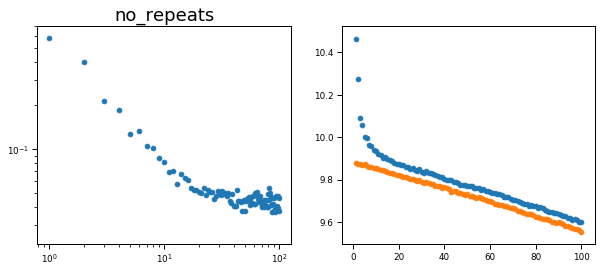

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of 100 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of 100 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


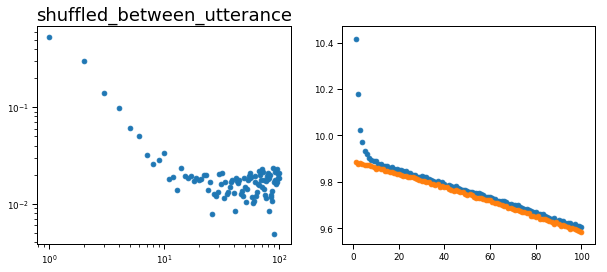

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of 100 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  37 out of 100 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


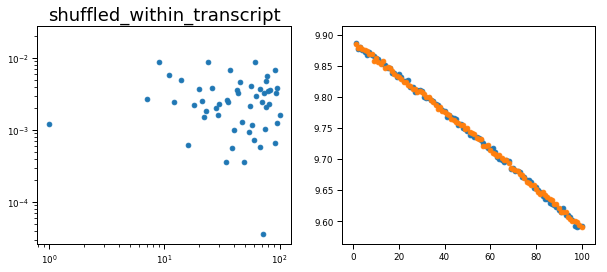

In [24]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        "median_n_phones",
        'shuffling'
    ]
)
    # for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts[::-1]):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    median_n_phones = int(np.median(cohort_subset.n_phones.values))

    ### make list of phones
    cohort_phones_list = [
        [
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ]
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list:', [' '.join(i) for i in cohort_phones_list][0][:100])
    
    shuffled_within_transcript = [np.random.permutation(i) for i in cohort_phones_list]
    print('phones list (shuffled within transcript):', [' '.join(i) for i in cohort_phones_list][0][:100])
    
    cohort_phones_list_no_repeats = [
        remove_repeats([
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ])
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (no repeats):', [' '.join(i) for i in cohort_phones_list_no_repeats][0][:100])

    ### make list of phones shuffled within words
    cohort_phones_list_shuffled_within_words = [
            list(concat([np.random.permutation(list(i)) for i in flatten(row.phones) if i is not None]))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled within word):', [' '.join(i) for i in cohort_phones_list_shuffled_within_words][0][:100])

    ### make list of phones shuffled between words
    cohort_phones_list_shuffled_between_words = [
            list(''.join(list(np.random.permutation([i for i in flatten(row.phones) if i is not None]))))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled between word):', [' '.join(i) for i in cohort_phones_list_shuffled_between_words][0][:100])

    cohort_phones_list_shuffled_within_utterance = [list(np.concatenate([np.random.permutation(list(''.join(list(flatten([i for i in sent if i is not None]))))) for sent in  trans]))
     for trans in cohort_subset.phones.values]
    print('phones list (shuffled within utterances):', [' '.join(i) for i in cohort_phones_list_shuffled_within_utterance][0][:100])

    cohort_phones_list_shuffled_between_utterance = [''.join([''.join(flatten([word for word in utterance if word is not None])) for utterance in np.random.permutation(trans)]) 
                                                     for trans in cohort_subset.phones.values];
    print('phones list (shuffled between utterances):', [' '.join(i) for i in cohort_phones_list_shuffled_between_utterance][0][:100])

    
    # get number of unique elements
    n_phones = len(np.concatenate(cohort_phones_list))
    n_unique_phones = 0 #len(np.unique(np.concatenate(cohort_phones)))
    
    distances = np.arange(1, np.max([100, median_n_phones]) + 1)
    
    # make each phone symbol specific to the transcript
    for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
        cohort_phones_list[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list[transcript_i]]
        cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
        cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
        cohort_phones_list_shuffled_within_utterance[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_within_utterance[transcript_i]]
        cohort_phones_list_no_repeats[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_no_repeats[transcript_i]]
        cohort_phones_list_shuffled_between_utterance[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_utterance[transcript_i]]
        shuffled_within_transcript[transcript_i] = [str(transcript_i) + i for i in shuffled_within_transcript[transcript_i]]

    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        median_n_phones,
        'full'
    ]
    quickplot_decay(distances, MI, shuff_MI, title='full')

    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_words, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        median_n_phones,
        'shuffled_within_words'
    ]
    quickplot_decay(distances, MI, shuff_MI, title='shuffled_within_words')
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_between_words, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        median_n_phones,
        'shuffled_between_words'
    ]
    quickplot_decay(distances, MI, shuff_MI, title='shuffled_between_words')
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_utterance, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        median_n_phones,
        'shuffled_within_utterance'
    ]
    quickplot_decay(distances, MI, shuff_MI, title='shuffled_within_utterance')
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_no_repeats, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        median_n_phones,
        'no_repeats'
    ]
    quickplot_decay(distances, MI, shuff_MI, title='no_repeats')
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_between_utterance, distances=distances, n_jobs=-1
    )
    
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        median_n_phones,
        'shuffled_between_utterance'
    ]
    quickplot_decay(distances, MI, shuff_MI, title='shuffled_between_utterance')
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        shuffled_within_transcript, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        median_n_phones,
        'shuffled_within_transcript'
    ]
    quickplot_decay(distances, MI, shuff_MI, title='shuffled_within_transcript')
    mi_df.to_pickle(DATA_DIR / "mi" / "phonbank_mi_full_median_shuffled.pickle")

In [25]:
mi_df[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,median_n_phones,shuffling
0,"[10.462783652449525, 9.983388971328182, 9.7520...","[0.0049862970087629875, 0.004861915778448901, ...","[9.581032058713163, 9.580828108367228, 9.58096...","[0.004776055346142387, 0.004775665750301762, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,310065,0,1574,full
1,"[5.740400393887644, 5.659412386387666, 5.62936...","[0.009623133671282348, 0.009617792466309692, 0...","[5.60940114322489, 5.609992145894537, 5.609532...","[0.009598316995692623, 0.009589218644341833, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,310065,0,1574,shuffled_within_words
2,"[10.41829005815009, 9.936921844638222, 9.69985...","[0.004978099712851141, 0.00484636226919765, 0....","[9.579728969514637, 9.581403782018807, 9.57992...","[0.004774484282599742, 0.004775984491959822, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,310065,0,1574,shuffled_between_words


In [26]:
#mi_df.to_pickle(DATA_DIR / "mi" / "phonbank_mi_with_shuffling_median.pickle")

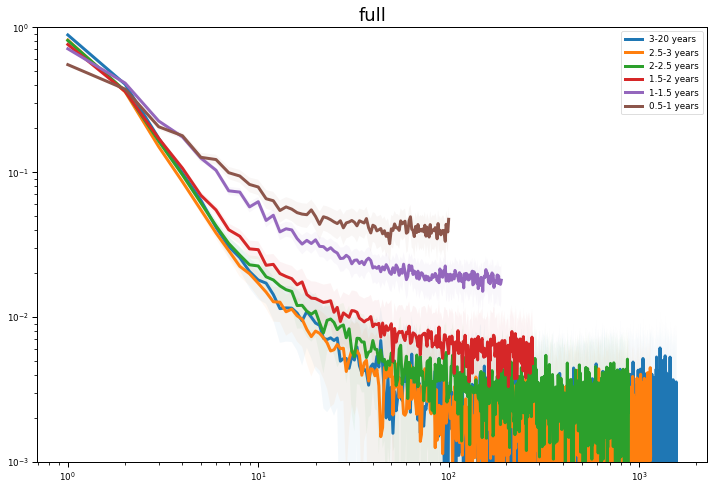

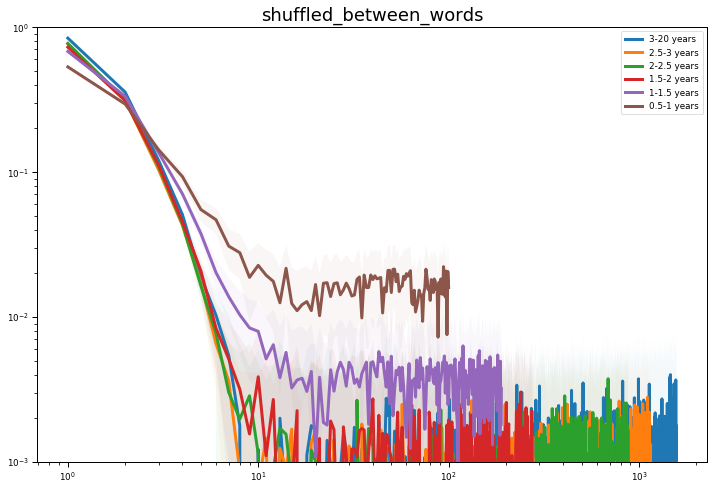

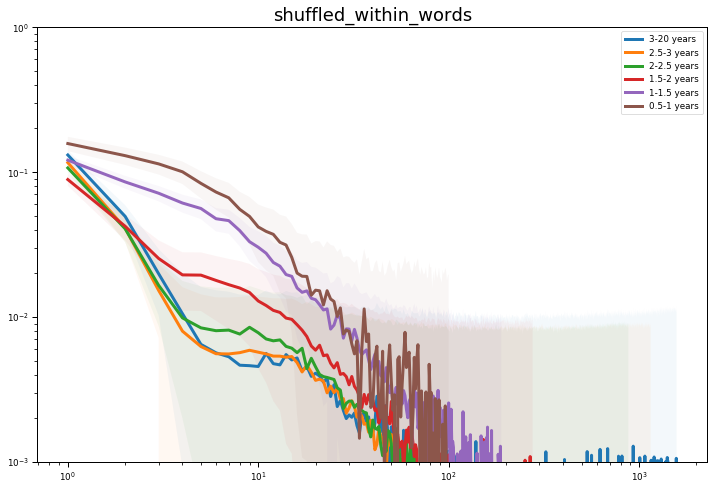

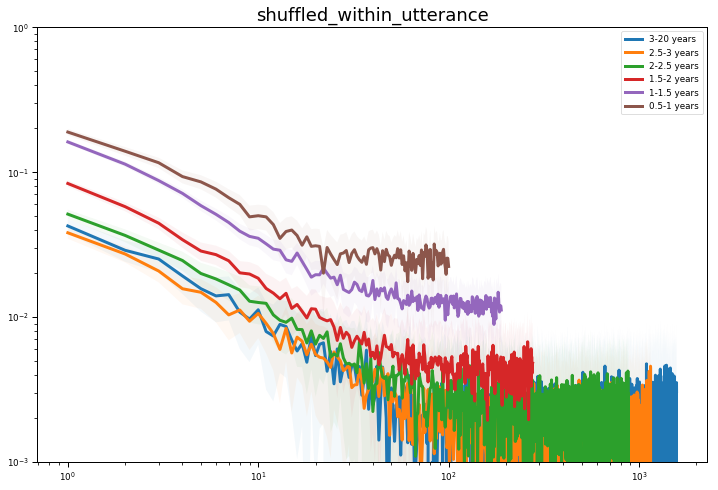

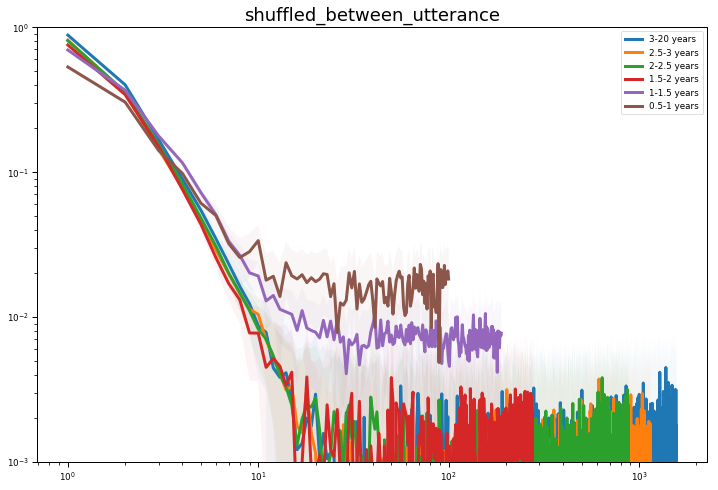

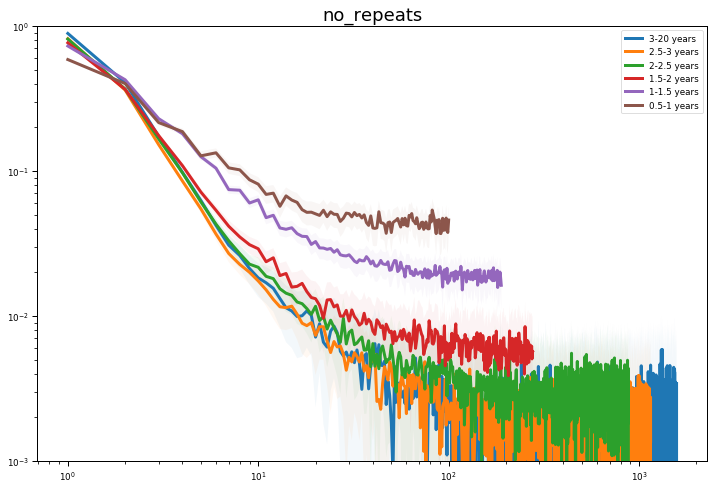

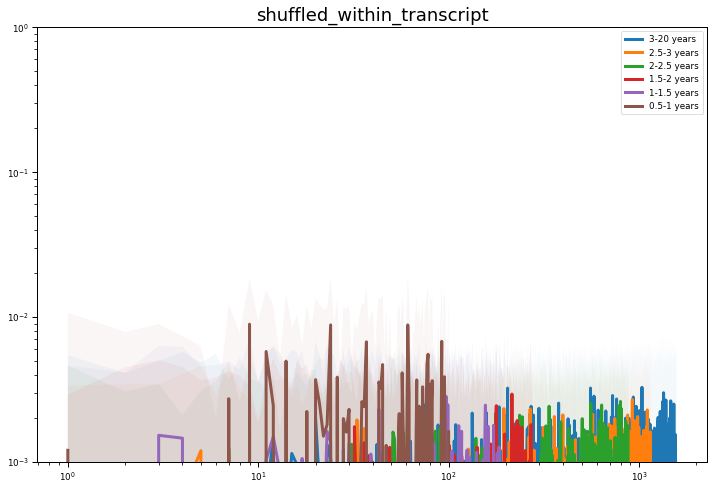

In [27]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_utterance', 'shuffled_between_utterance', 'no_repeats', 'shuffled_within_transcript']:
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title(shuff)
    for idx, row in mi_df.iterrows():
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax.plot(row.distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.05)

    ax.legend()
    ax.set_ylim([1e-3,1])
    #ax.set_xlim([1, 100])

    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()

full


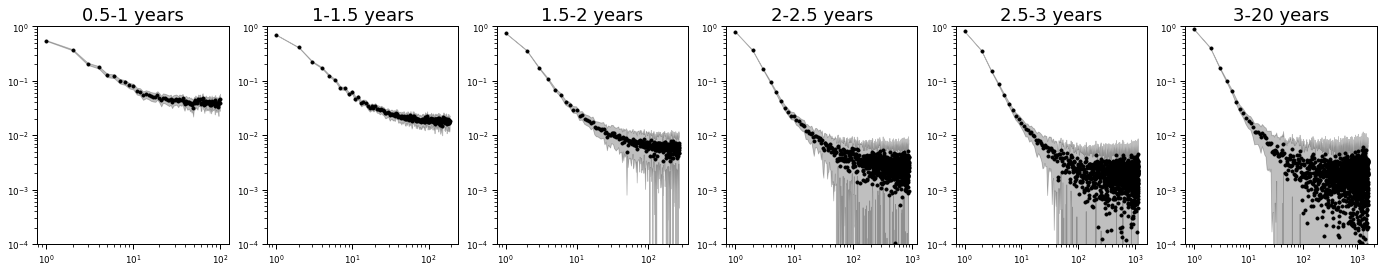

shuffled_between_words


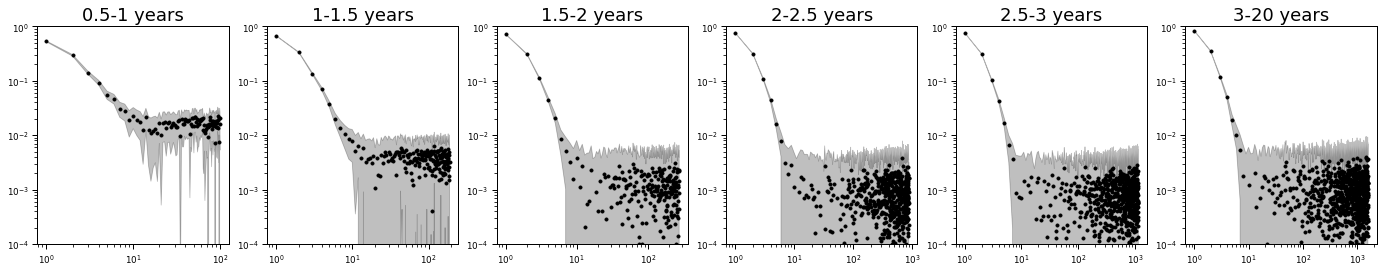

shuffled_within_words


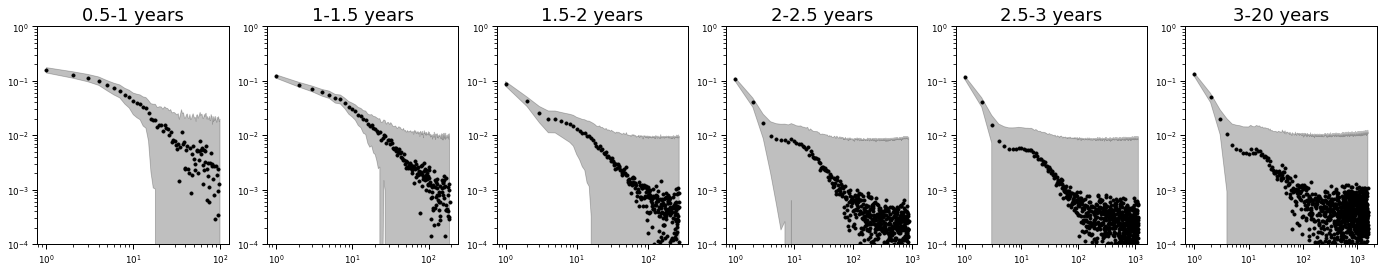

shuffled_within_utterance


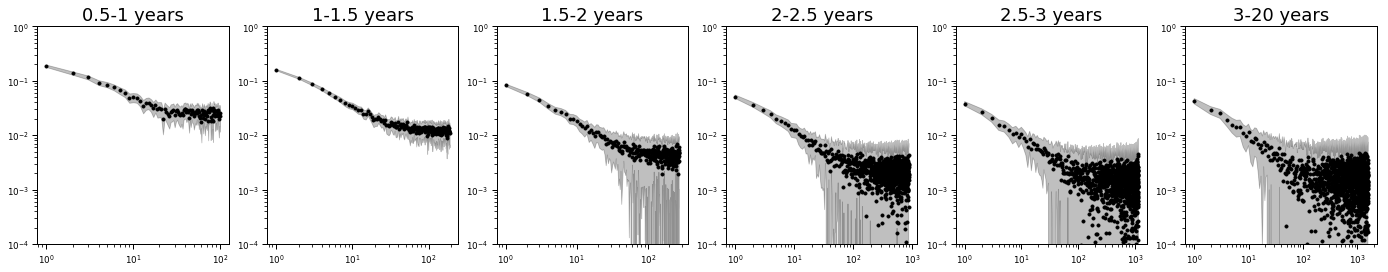

shuffled_between_utterance


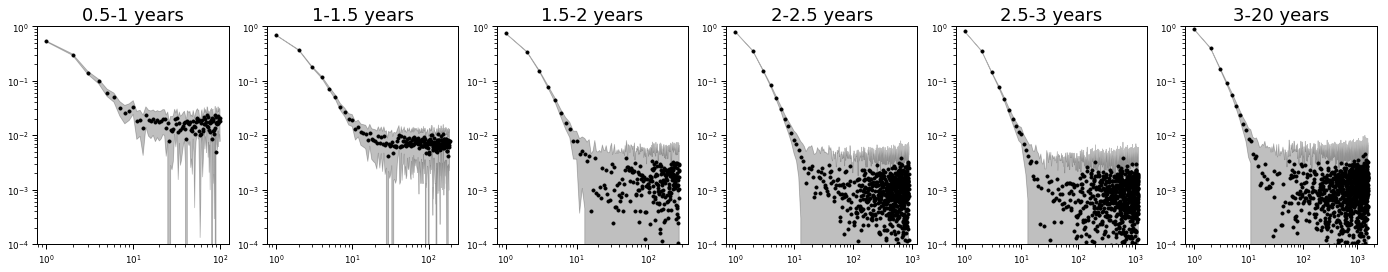

no_repeats


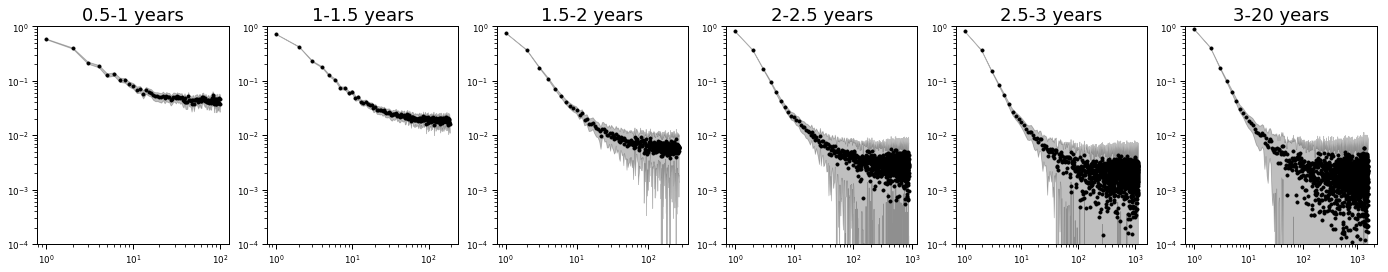

shuffled_within_transcript


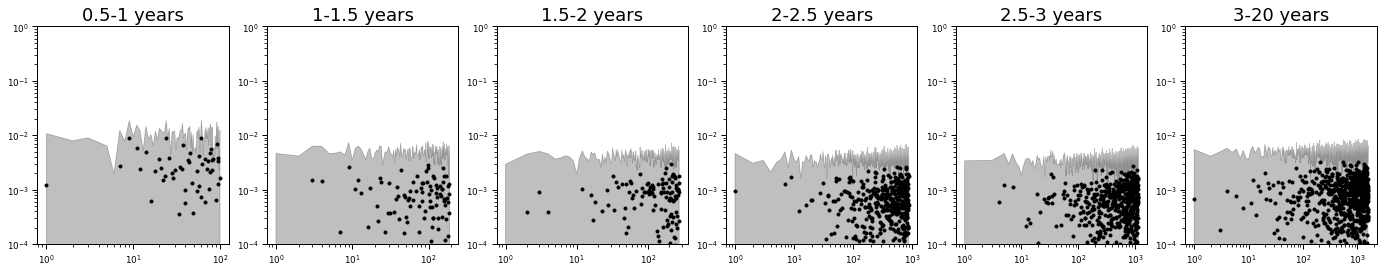

In [28]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_utterance', 'shuffled_between_utterance', 'no_repeats', 'shuffled_within_transcript']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.scatter(row.distances, row.MI-row.shuff_MI, s=10, color='k')
        ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        ax.set_ylim([1e-4,1])
        #ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()

full


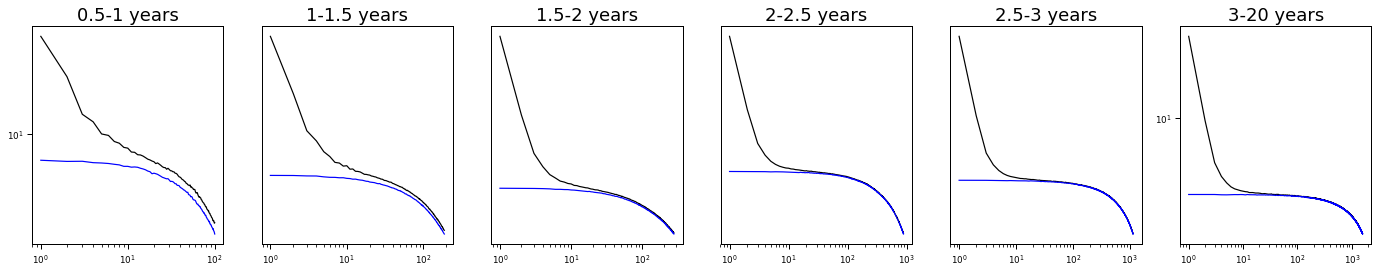

shuffled_between_words


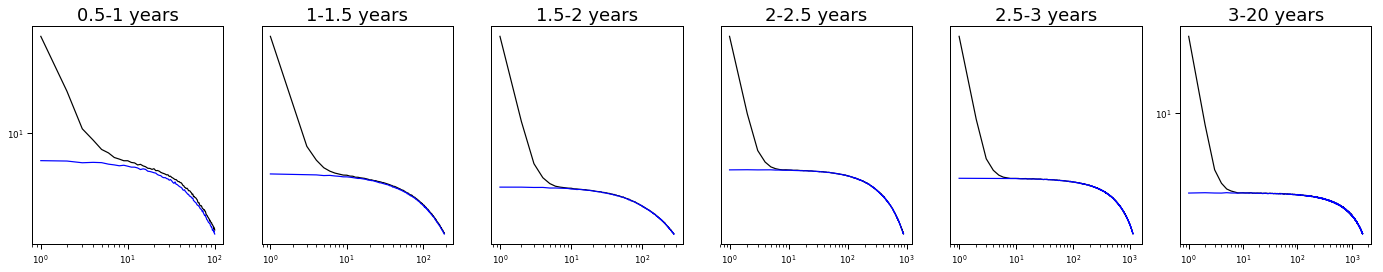

shuffled_within_words


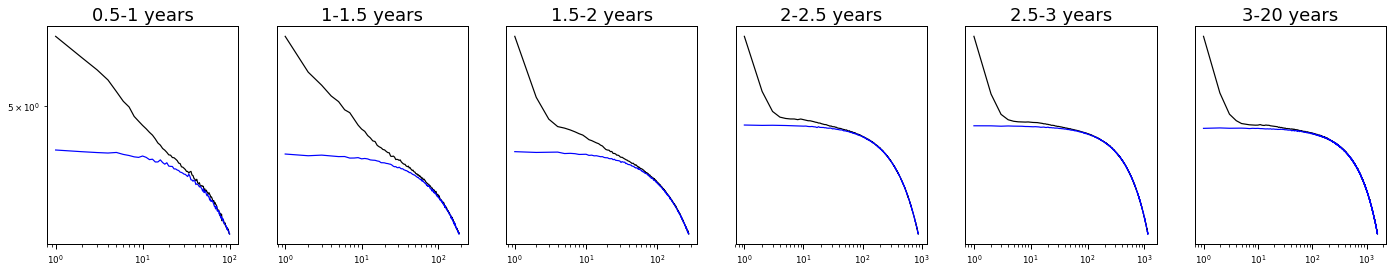

shuffled_within_utterance


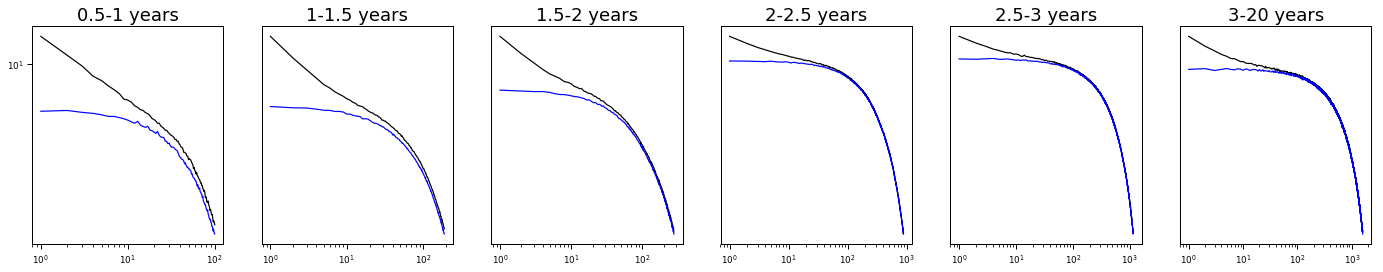

shuffled_between_utterance


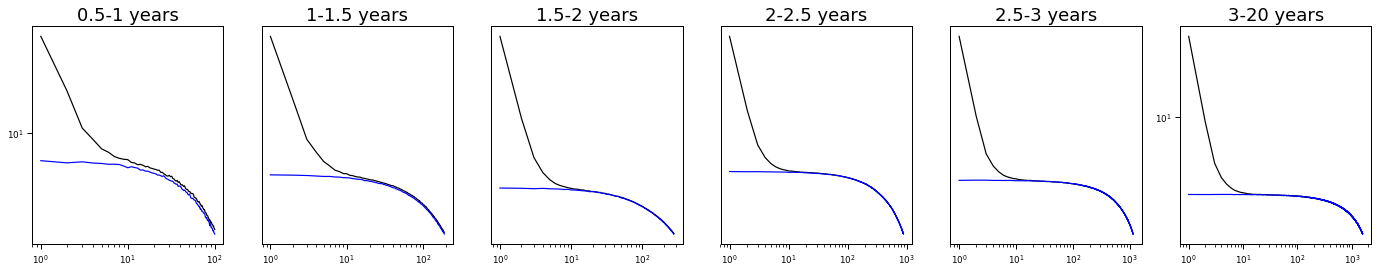

no_repeats


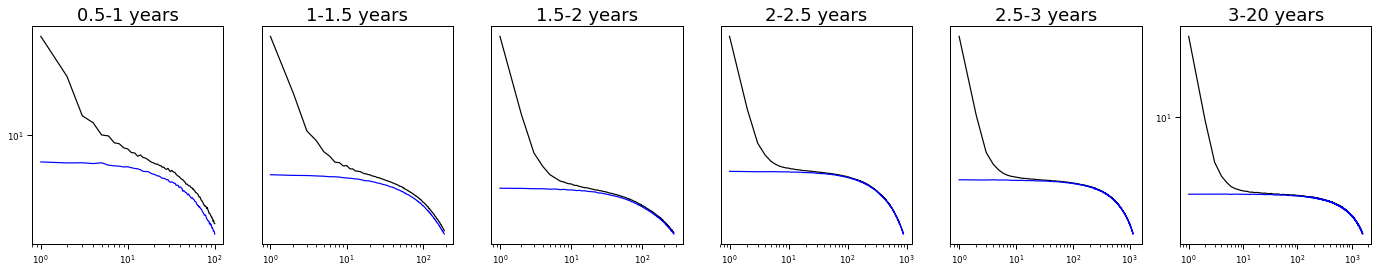

shuffled_within_transcript


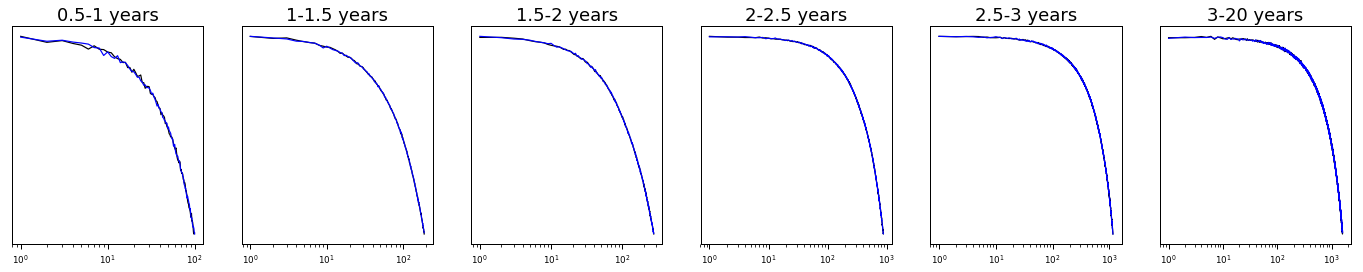

In [29]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_utterance', 'shuffled_between_utterance', 'no_repeats', 'shuffled_within_transcript']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.plot(row.distances, row.MI, color='k')
        ax.plot(row.distances, row.shuff_MI, color='b')
        #ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        #ax.set_ylim([1e-4,1])
        #ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()